## MaskRCNN-based model for motif identification

We assume $n=1000$ input sequences $X$ (of length $l=100$) containing one motif each and each motif has one to one correspondence with a module. We assume a total of $r=3$ modules and each sequence has a module identity $I$. We model the motifs as position weight matrices (PWMs) whose widths $w$ are bounded above by a particular value (20). The starting postion of each motif is represented by $Z$ and with the (obvious) constraint: $0 < Z < n-l$. The background DNA in each sequence that do not belong to any sequence are *assumed* to follow a (second order) Markov probability model (the probability of given BP inside X is conditioned on the the values of 2 BPs that appear before it, $P(X_u = B_1) = \phi(B_1|X_{u-2}, X_{u-1})$. The support of base pair values $(B)$ is the set: $\text{range}(4)$.

Let's first import necessary libraries and define some global variables:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from scipy import integrate, special
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, TraceGraph_ELBO

In [2]:
n = 2000
batch = 50 #Minibatch for sub-sampling
l = 100
r = 3

Now, we'll write some code to simulate our input data X. For that we need to fix some ground-truth values of various latent variables. Later when we define and train an SVI (stochastic variational inference) based model on the generated X, a good model is expected to reproduce these ground truth values (names end with $0$ as a convention). So let's get to it!

First we generate some ground truth values of latent variables:

In [3]:
prior = dist.Dirichlet(torch.ones([4, 4, 4]))  # type: ignore
# Distribution from which Markov probabilities will be drawn from
phi0 = prior.sample()
print(phi0.shape)

torch.Size([4, 4, 4])


The size of $[4,4,4]$ reflects the conditional probability on a support set of size 4, over two similar variables whose support is $[4]$ each, resulting in the given array size.

Now, we will sample motif widths $w$ and their pwm:

In [4]:
w0 = torch.randint(5, 20, size=(r,))
d = dist.Categorical(torch.full([4], 0.25))
pwm0 = d.sample([r, 20])
print(pwm0)
# The actual pwm are slices determined by w
# not the whole sequences of width 20 each

tensor([[0, 2, 3, 2, 2, 3, 0, 3, 0, 3, 2, 1, 0, 2, 3, 1, 3, 0, 0, 1],
        [3, 1, 2, 1, 0, 0, 3, 0, 2, 2, 1, 0, 2, 1, 2, 1, 3, 3, 2, 3],
        [3, 1, 3, 1, 3, 2, 0, 3, 1, 0, 2, 0, 3, 1, 1, 1, 3, 1, 3, 0]])


Next, we generate module identities $I$ and motif starting positions $Z$:

In [5]:
prob = dist.Dirichlet(torch.full([n, r], 4.)).sample()
d = dist.Categorical(prob)
I0 = d.sample()
I0.shape

torch.Size([2000])

In [6]:
Z0 = torch.empty([n], dtype=torch.int32)
d = dist.Beta(4., 4.)

for i in range(n):
    num = d.sample()
    num = num*(l-w0[I0[i]])
    Z0[i] = num.round().int()
    
Z0[:100]

tensor([65, 42, 37, 24, 26, 60, 53, 29, 45, 48, 47, 39, 40, 28, 42, 45, 48, 33,
        13, 62, 61, 71, 54, 52, 55, 30, 40, 42, 11, 61, 30, 56, 20, 45, 38, 55,
        37, 61, 65, 48, 22, 16, 49, 32, 25, 22, 56, 52, 59, 67, 53, 52, 41, 55,
        65, 74, 37, 39, 58, 66, 33, 63, 42, 17, 58, 59, 19, 40, 32, 57, 38, 58,
        40, 50, 51,  8, 66, 69, 56, 46, 28, 44, 34, 66, 61, 32, 55, 27, 37, 50,
        78, 40, 60, 46, 34, 53, 50, 71, 22, 49], dtype=torch.int32)

Using the ground truth values generated, we will generate the input data $X$. Remember that only this $X$ will be fed to the SVI model for training.

In [7]:
X = torch.empty([n, l], dtype=torch.int32)

for i in range(n):
    prob = torch.mean(phi0, (0, 1))
    X[i, 0] = dist.Categorical(prob).sample()
    prob = torch.mean(phi0, dim=0)[X[i, 0], :]
    X[i, 1] = dist.Categorical(prob).sample()

    for u in range(2, Z0[i]):  # Markov sampling for bg DNA
        prob = phi0[X[i, u-2], X[i, u-1], :]
        X[i, u] = dist.Categorical(prob).sample()

    X[i, Z0[i]:Z0[i]+w0[I0[i]]] = pwm0[I0[i], :w0[I0[i]]]  # Motif at pos Z[i]

    for u in range(Z0[i]+w0[I0[i]], l):  # Markov sampling for bg DNA
        prob = phi0[X[i, u-2], X[i, u-1], :]
        X[i, u] = dist.Categorical(prob).sample()
        
X = X.to(torch.int64)

In [8]:
X[1], Z0[1], w0[I0[1]]

(tensor([1, 2, 1, 1, 1, 1, 1, 1, 0, 3, 0, 3, 1, 1, 2, 3, 2, 2, 1, 0, 0, 2, 1, 0,
         3, 1, 0, 3, 0, 1, 0, 3, 0, 3, 1, 3, 3, 0, 2, 1, 0, 1, 3, 1, 3, 1, 3, 2,
         0, 3, 1, 0, 2, 0, 3, 1, 1, 1, 3, 1, 3, 0, 2, 0, 0, 0, 2, 2, 2, 1, 0, 3,
         1, 0, 1, 3, 1, 0, 1, 2, 3, 2, 3, 2, 1, 0, 3, 0, 1, 2, 3, 2, 2, 1, 0, 2,
         1, 0, 0, 1]),
 tensor(42, dtype=torch.int32),
 tensor(19))

In [36]:
torch.save(pwm0, "saved_pwm.pt")
torch.save(w0, "saved_w.pt")
torch.save(phi0, "saved_phi.pt")
torch.save(Z0, "saved_Z.pt")
torch.save(I0, "saved_I.pt")
torch.save(X, "saved_X.pt")

Let's define custom distributions that'll be useful in the SVI model we're going to use:

In [3]:
# function that integrates the Beta distribution's pdf
def beta_integral(x1, x2, a: torch.Tensor, b: torch.Tensor):
    def beta_pdf(x):
        return (x**(a-1))*((1-x)**(b-1))/special.beta(a, b)
    
    return integrate.quad(beta_pdf, x1, x2)[0]
    
class DiscretizedBeta(dist.TorchDistribution):
    def __init__(self, low, high, conc1, conc2):
        self.beta = dist.Beta(conc1, conc2)
        self.low = low
        self.high = high
        self.a = conc1.detach().numpy()
        self.b = conc2.detach().numpy()
        
        prob = torch.empty(size=[high-low], dtype=torch.float32)
        x = np.linspace(0., 1., high-low+1)
        for i in torch.arange(high-low):
            prob[i] = beta_integral(x[i], x[i+1], self.a, self.b)
        
        self.categorical = dist.Categorical(prob)
        
        super().__init__(self.beta.batch_shape, self.beta.event_shape,
                         validate_args=False)
        
    def sample(self, sample_shape=torch.Size()):
        return self.categorical.sample(sample_shape) + self.low
    
    def log_prob(self, value):
        return self.categorical.log_prob(value-self.low)

In [4]:
d = DiscretizedBeta(0, 10, torch.tensor(2.), torch.tensor(2.))

<BarContainer object of 6 artists>

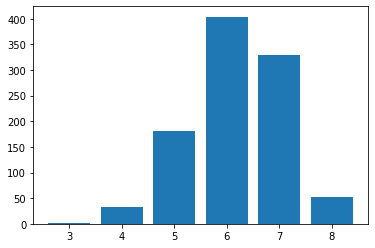

In [11]:
x = d.sample(torch.tensor([1000]))
y = np.histogram(x, np.arange(x.min(), x.max()+2)-0.5)
plt.bar(np.arange(x.min(), x.max()+0.5), y[0])

<BarContainer object of 10 artists>

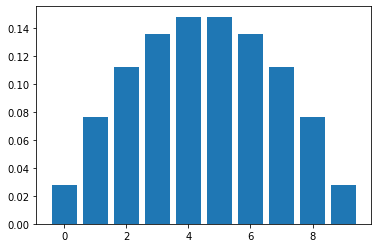

In [5]:
x = torch.arange(0, 10)
plt.bar(x, torch.exp(d.log_prob(x)))

## Brute force strategy

Let's define a model function that assigns a prior distributions for various latent variables and samples them to generate various components of X:

In [47]:
def model(low, size):
    phi_prior = dist.Delta(torch.full([4, 4, 4], 0.25))
    
    with pyro.plate("phi loop1", 4):
        with pyro.plate("phi loop2", 4):
            with pyro.plate("phi loop3", 4):
                phi = pyro.sample("phi", phi_prior)
    phi_1 = torch.mean(phi, dim=0)
    phi_0 = torch.mean(phi_1, dim=0)
    
    pwm_prior = dist.Delta(torch.full([r, 20, 4], 0.25))
    with pyro.plate("pwm loop1", 4):
        with pyro.plate("pwm loop2", 20):
            with pyro.plate("pwm loop3", r):
                pwm = pyro.sample("pwm", pwm_prior)
    
    w_prior = DiscretizedBeta(5, 20, torch.tensor(1.), 
                              torch.tensor(1.))
    w = torch.empty([r], dtype=torch.int64)
    for j in pyro.plate("w loop", r):
        w[torch.tensor(j)] = pyro.sample("w_{}".format(j),
                                         w_prior)
    
    for i in pyro.plate("Batch", size):
        i = i + low
        
        I_prior = dist.Categorical(logits=torch.ones([r]))
        I = pyro.sample("I_{}".format(i), I_prior)
        
        Z_prior = dist.Categorical(logits=torch.ones([l - w[I]]))
        Z = pyro.sample("Z_{}".format(i), Z_prior)
        
        for u in pyro.markov(range(l), history=2): #type: ignore
            if (u < Z) or (u > Z+w[I]):
                if u == 0:
                    pyro.sample("X_{},0".format(i),
                                dist.Categorical(probs=phi_0),
                                obs=X[i, u])
                elif u == 1:
                    pyro.sample("X_{},1".format(i),
                                dist.Categorical(probs=phi_1[X[u-1]]),
                                obs=X[i, u])
                else:
                    pyro.sample("X_{},{}".format(i, u), 
                                dist.Categorical(probs=phi[X[i,u-2], X[i,u-1]]),
                                obs=X[i, u])
            else:
                pyro.sample("X_{},{}".format(i, u),
                            dist.Categorical(probs=pwm[I, u-Z]),
                            obs=X[i, u])

In the guide function, we generate the (2nd order) backgorund Markov distribution $phi$ from a softmax-activated trainable parameter. We put nested "pyro.plate"s since the components are independent of each other. $pwm$ is also sampled similarly. The motif width $w$ is sampled from a "DiscretizedBeta" distribution among values in the interval $[5, 20]$. Given these latent variables, we need to find out the remaining variables $I$ and $Z$ that also happen to depend on the input data $X$. For predicting I and Z, the brute-force way is obviously elementwise-multiplying the ith pwm (sliced with w) at every possible position Z and then multiplying the remaining sequence with background distribution phi. Multiplying the elements of these probability vectors gives us a "score" for every possible value of the pair {I, Z}. This process becomes more and more costly as the values of l and r increase, though. So when this becomes parctically intractable, we can use estimators like neural networks to approximate this.

Let's define the "brute-force" guide function:

In [ ]:
def guide_bf(low, size):
    phi_param = pyro.param("phi_param", torch.ones([4,4,4]))
    softmax = nn.Softmax(-1)
    d = dist.Delta(softmax(phi_param))
    with pyro.plate("phi loop1", 4):
        with pyro.plate("phi loop2", 4):
            with pyro.plate("phi loop3", 4):
                phi = pyro.sample("phi", d)
    phi_1 = torch.mean(phi, dim=0)
    phi_0 = torch.mean(phi_1, dim=0)
    
    pwm_param = pyro.param("pwm_param", torch.full([r,20,4], 0.1))
    d = dist.Dirichlet(pwm_param)
    with pyro.plate("pwm loop1", 4):
        with pyro.plate("pwm loop2", 20):
            with pyro.plate("pwm loop3", r):
                pwm = pyro.sample("pwm", d)
    
    w_param = pyro.param("w_param", torch.ones([r, 2]))**2
    d = [DiscretizedBeta(5, 21, w_param[j, 0], w_param[j, 1])
         for j in range(r)]
    w = torch.empty([r], dtype=torch.int64).detach()
    for j in pyro.plate("w loop", r):
        w[torch.tensor(j)] = pyro.sample("w_{}".format(j), d[torch.tensor(j)])
    
    Xoh = F.one_hot(X[low:low+size, :], 4).float()
    
    for i in pyro.plate("Batch", size):
        i = i + low
        y1 = torch.empty([r]).detach()
        y2 = []
        # Loop over every possible I and Z
        for j in torch.arange(r):
            y = torch.empty((l-w[j], l)).detach()
            for z in torch.arange(l-w[j]):
                for u in torch.arange(z):
                    if u == 0:
                        y[z, u] = torch.dot(Xoh[i, u, :],
                                            phi_0)
                    elif u == 1:
                        y[z, 1] = torch.dot(Xoh[i, u, :],
                                            phi_1[0, :])
                    else:
                        y[z, u] = torch.dot(Xoh[i, u, :], 
                                        phi[X[i, u-2], X[i, u-1], :])
                        
                for u in torch.arange(z, z+w[j]):
                    y[z, u] = torch.dot(Xoh[i, u, :],
                                        pwm[j, u-z, :])
                for u in torch.arange(z+w[j], l):
                    y[z, u] = torch.dot(Xoh[i, u, :],
                                        phi[X[i, u-2], X[i, u-1], :])
            y = torch.log(y)
            y2.append(y)
            y = torch.sum(y, 1)
            y1[j] = torch.logsumexp(y, 0)
        I = pyro.sample("I_{}".format(i), dist.Categorical(logits=y1))
        
        pyro.sample("Z_{}".format(i), dist.Categorical(logits=y2[I]))

In [35]:
def train_bf(epochs=10, batch_size=100):
    # Clear out other trainable parameters in the current REPL/ipython kernel
    # session
    pyro.clear_param_store()
    opt = torch.optim.Adam
    scheduler = optim.StepLR({"optimizer": opt, "step_size": 250, "gamma": 0.2,  # type: ignore
                              "optim_args": {"lr": 0.001, "betas": (0.9, 0.999)}})
    svi = SVI(model, guide_bf, scheduler, loss=Trace_ELBO())

    for epoch in range(epochs):
        steps_per_epoch = n//batch_size
        low = 0
        for step in range(steps_per_epoch):
            svi.step(low, batch_size)
        scheduler.step()

In [ ]:
# train_bf(100)

For a lot of reasons, the "brute force" guide function doesn't seem to be viable (and it crashed my laptop's RAM). For example, calculating the ELBO loss involves averaging over samples of latent variables $z$ (wrt the guide function) a large number of times. Also, log probabilities of these predictioned must be tracked too. So when the guide function makes a calculation of size $O(\text{batchsize}*l^2*r)$ in order to predict $I$ and $Z$, we were all seeing it here. Moreover, multiplying together $l=100$ number of probabilities won't be numerically stable enough for gradients wrt to the parameters defined inside the guide.

## Plain neural strategy

This means we need a different guide function which is a lot more cheaper to evaluate and numerically stable. Since we tracked these problems to the part where we sampled $I$ and $Z$ in guide_bf, we'll build a neural network that takes X as input and outputs certain distribution parameters associated with the latent variables $I$ and $Z$.

In [11]:
# A neural network that outputs categorical params of I
# and Delta center of Z. Some RPN inspiration seems neccessary!
class MotifCNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv1d(4, 16, 5, padding='valid'), # l=96
            nn.Mish(),
            nn.MaxPool1d(2), # l=48
            nn.Conv1d(16, 16, 5, padding='valid'), # l=44
            nn.Mish(),
            nn.MaxPool1d(2), # l=22
            nn.Conv1d(16, 16, 3, padding='valid'), # l=20
            nn.Mish(),
            nn.MaxPool1d(2) # l=10
        )
        self.I_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(10*16, 32),
            nn.Mish(),
            nn.Linear(32, r),
            nn.Softmax(dim=-1)
        )
        self.shared_conv = nn.Conv1d(16, r, 3, padding='same')
        self.prob_conv = nn.Conv1d(1, 1, 1)
        self.delta_conv = nn.Conv1d(1, 1, 1)
    
    def predict_I(self, x: torch.Tensor):
        x = self.backbone(x)
        return self.I_head(x)
        
    def predict_Z(self, x: torch.Tensor, I: torch.Tensor):
        x = self.backbone(x)
        shared = self.shared_conv(x)[:, I:I+1, :]
        shared = F.mish(shared)
        
        probs = self.prob_conv(shared)
        probs = torch.squeeze(F.softmax(probs, -1))
        
        deltas = self.delta_conv(shared)
        deltas = torch.squeeze(torch.sigmoid(deltas))
        
        return probs, deltas
    

motif_cnn = MotifCNN()
motif_cnn = pyro.module("Motif CNN", motif_cnn)

In [12]:
class DisplacedCategorical(dist.TorchDistribution):
    def __init__(self, probs, interval):
        self.interval = interval
        self.categorical = dist.Categorical(probs)
        super().__init__(self.categorical.batch_shape,
                         self.categorical.event_shape,
                         validate_args=False)

    def sample(self, sample_shape=torch.Size()):
        return self.interval[self.categorical.sample(sample_shape)]

    def log_prob(self, value):
        def f(v):
            if v in self.interval:
                return torch.where(self.interval==v)[0][0]
            else:
                return torch.tensor(-1)
        
        return self.categorical.log_prob(f(value))

In [26]:
def model2(low, size):
    phi_prior = dist.Delta(torch.full([4, 4, 4], 0.25))
    
    with pyro.plate("phi loop1", 4):
        with pyro.plate("phi loop2", 4):
            with pyro.plate("phi loop3", 4):
                phi = pyro.sample("phi", phi_prior)
    phi_1 = torch.mean(phi, dim=0)
    phi_0 = torch.mean(phi_1, dim=0)
    
    pwm_prior = dist.Dirichlet(torch.full([r, 20, 4], 0.1))
    with pyro.plate("pwm loop2", 20):
        with pyro.plate("pwm loop3", r):
            pwm = pyro.sample("pwm", pwm_prior)
    
    w_prior = DiscretizedBeta(5, 21, torch.tensor(1.), 
                              torch.tensor(1.))
    w = torch.empty([r], dtype=torch.int64)
    for j in pyro.plate("w loop", r):
        w[torch.tensor(j)] = pyro.sample("w_{}".format(j),
                                         w_prior)
    
    I_prior = dist.Categorical(logits=torch.ones([size,r]))
    with pyro.plate("I loop", size):
        I = pyro.sample("I_{}:{}".format(low, low+size), 
                        I_prior)
    
    for i in pyro.plate("Z loop", size):
        i = i + low
        
        Z_prior = dist.Categorical(logits=torch.ones([l - w[I[i-low]]]))
        Z = pyro.sample("Z_{}".format(i), Z_prior)
        
        for u in pyro.markov(range(l), history=2): #type: ignore
            if u==0 and Z>0:
                pyro.sample("X_{},0".format(i),
                            dist.Categorical(probs=phi_0),
                            obs=X[i, u])
            elif u==1 and Z>1:
                pyro.sample("X_{},1".format(i),
                            dist.Categorical(probs=phi_1[X[i,0]]),
                            obs=X[i, u])
            elif ((u > 1) and (u < Z)) or (u >= Z+w[I[i-low]]):
                pyro.sample("X_{},{}".format(i, u), 
                            dist.Categorical(probs=phi[X[i,u-2], X[i,u-1]]),
                            obs=X[i, u])
            elif (u >= Z) and (u < Z+w[I[i-low]]):
                pyro.sample("X_{},{}".format(i, u),
                            dist.Categorical(probs=pwm[I[i-low], u-Z]),
                            obs=X[i, u])

Here's the neural network-enabled guide function:

In [35]:
def guide_neural1(low, size):
    phi_param = pyro.param("phi_param", torch.ones([4, 4, 4]))
    softmax = nn.Softmax(-1)
    d = dist.Delta(softmax(phi_param))
    with pyro.plate("phi loop1", 4):
        with pyro.plate("phi loop2", 4):
            with pyro.plate("phi loop3", 4):
                phi = pyro.sample("phi", d)

    pwm_param = pyro.param("pwm_param", torch.full([r, 20, 4], 0.1))
    d = dist.Dirichlet(pwm_param)
    with pyro.plate("pwm loop2", 20):
        with pyro.plate("pwm loop3", r):
            pwm = pyro.sample("pwm", d)

    w_param = pyro.param("w_param", torch.ones([r, 2]))**2
    d = [DiscretizedBeta(5, 21, w_param[j, 0], w_param[j, 1])
         for j in range(r)]
    w = torch.empty([r], dtype=torch.int64)
    for j in pyro.plate("w loop", r):
        w[torch.tensor(j)] = pyro.sample("w_{}".format(j), d[torch.tensor(j)])
    
    Xoh = F.one_hot(X[low:low+size, :], 4).float()
    Xoh = torch.permute(Xoh, (0,2,1))
    print(Xoh.shape)
    
    params = motif_cnn.predict_I(Xoh)
    d = dist.Categorical(params)
    with pyro.plate("I loop", size):
        I = pyro.sample("I_{}:{}".format(low, low+size), d)
    
    for i in pyro.plate("Z loop", size):
        i = i + torch.tensor(0)
        y = Xoh[i:i+1, :, :]
        
        if i==0:
            print(y.shape)
        
        probs, deltas = motif_cnn.predict_Z(y, I[i])
        
        interval = torch.linspace(0, l-w[I[i]],
                                  probs.shape[0]+1)[:-1]
        spacing = interval[1]-interval[0]
        interval = torch.round(interval + (spacing*deltas)).long()
        d = DisplacedCategorical(probs, interval)
        pyro.sample("Z_{}".format(i+low), d)

torch.Size([100, 4, 100])
torch.Size([1, 4, 100])


In [15]:
from tqdm.notebook import tqdm_notebook

In [31]:
def train_neural1(epochs=10, batch_size=100):
    # Clear out other trainable parameters in the current REPL/ipython kernel
    # session
    pyro.clear_param_store()
    opt = torch.optim.Adam
    scheduler = optim.StepLR({"optimizer": opt, "step_size": 50, "gamma": 0.2,  # type: ignore
                              "optim_args": {"lr": 0.01, "betas": (0.9, 0.999)}})
    svi = SVI(model2, guide_neural1, scheduler, loss=Trace_ELBO())

    for epoch in tqdm_notebook(range(epochs)):
        steps_per_epoch = n//batch_size
        low = 0
        for step in range(steps_per_epoch):
            svi.step(low, batch_size)
            low = low + batch_size
        scheduler.step()

In [32]:
train_neural1(100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
param_dict = pyro.get_param_store()
param_dict.save("saved_param_dict.pt")

In [34]:
torch.save(motif_cnn.state_dict(), "motif_cnn.pt")

Let's check how well the trained model infers the values of ground truth latent variables:

In [37]:
param_dict.load("saved_param_dict.pt")
motif_cnn = MotifCNN()
motif_cnn = pyro.module("Motif CNN", motif_cnn)
motif_cnn.load_state_dict(torch.load("motif_cnn.pt"))

<All keys matched successfully>

In [ ]:
phi0 = torch.load("saved_phi.pt")
pwm0 = torch.load("saved_pwm.pt")
w0 = torch.load("saved_w.pt")
I0 = torch.load("saved_I.pt")
Z0 = torch.load("saved_Z.pt")
X = torch.load("saved_X.pt")

We can obtain the learned latent variables using the associated variational parameters or neural networks. Let's get some of them this way: